In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
import country_converter as coco
import pypsa

import cartopy
import cartopy.crs as ccrs

from cartopy.io import shapereader


In [2]:
import cartopy.feature as cfeature

In [3]:
from matplotlib.lines import Line2D


In [5]:
from pypsa.plot import add_legend_patches


In [8]:
n1=pypsa.Network(r"./elec_s_256_lv1.25__Co2L0p29-6H-T-H-B-I-A-solar+p3-dist1_2030.nc")

INFO:pypsa.io:Imported network elec_s_256_lv1.25__Co2L0p29-6H-T-H-B-I-A-solar+p3-dist1_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


/Users/e7_qpham/miniconda3/envs/pypsa-eur/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/e7_qpham/miniconda3/envs/pypsa-eur/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


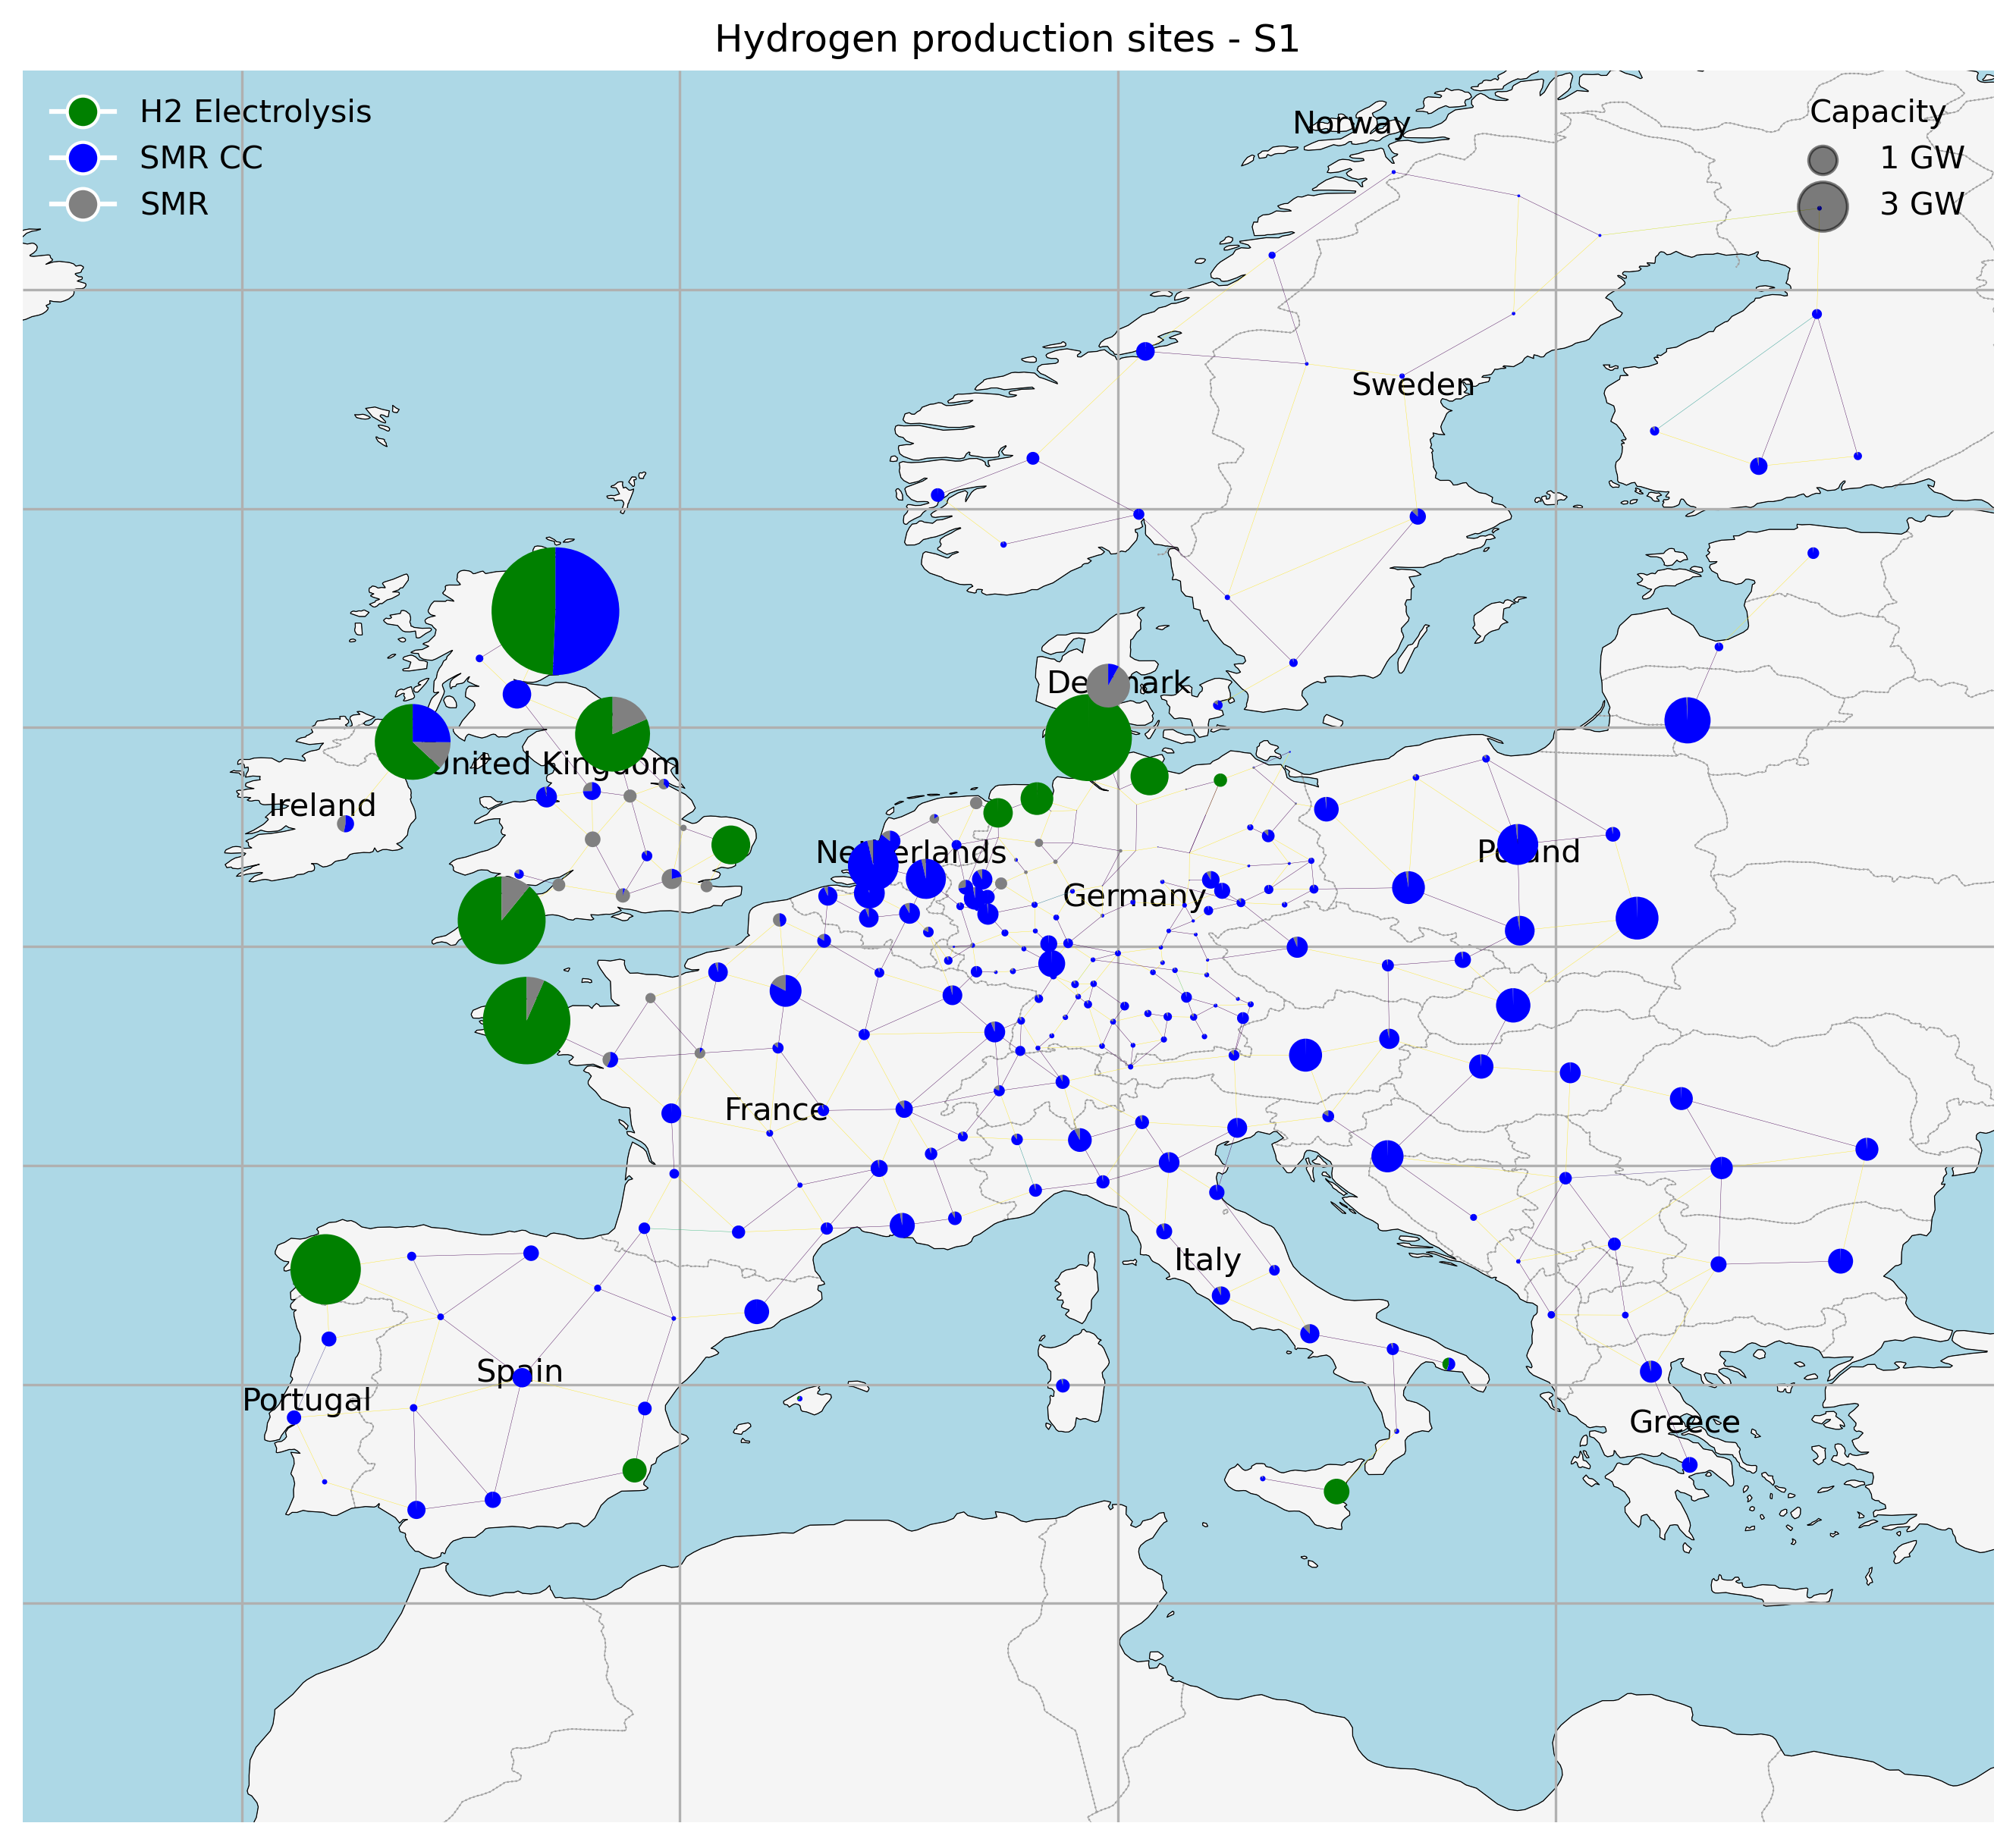

In [26]:
h2_sites1 = n1.links[n1.links.carrier.isin(["H2 Electrolysis", "SMR CC", "SMR"])].assign(l1=n1.links_t.p1.mean().abs()).groupby(["bus1", "carrier"]).l1.sum()
h2_sites1.index = h2_sites1.index.set_levels(h2_sites1.index.levels[0].str.replace(' H2', ''), level=0)

EUROPE_BOUNDS = [-15, 30, 30, 70]
carriers = ["H2 Electrolysis", "SMR CC", "SMR"]
colors = ["green", "blue", "gray"]

line_loading = n1.lines_t.p0.iloc[0] 
norm = plt.Normalize(vmin=0, vmax=100)

# Create a map with the PlateCarree projection centered on Europe

fig = plt.figure(figsize=(15, 10),dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree())


# Add features to the map
ax.add_feature(cfeature.LAND, linewidth=0.1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.1)
ax.add_feature(cfeature.BORDERS, linestyle=':', color="grey", linewidth=0.5)

# Additional code to add country names
# This requires the natural_earth package which contains shapefiles with country names and borders
# Assuming the shapefile is at the 50m resolution which is commonly used for maps at this scale
countries = shapereader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shapereader.Reader(countries)

# List of countries for which you want to display the full name
full_name_countries = ['Germany', 'Sweden', 'Denmark', 'Spain', 'France', 'Netherlands',
                       'Portugal', 'United Kingdom', 'Ireland', 'Italy', 'Greece', 'Poland', 'Norway']

# Define a function to check if a point is within the Europe bounds
def is_in_europe(x, y):
    lon_min, lon_max, lat_min, lat_max = EUROPE_BOUNDS
    return lon_min <= x <= lon_max and lat_min <= y <= lat_max

# Correct coordinates for France's label
france_label_coords = (2.2137, 46.2276)  

# Adding country names to the plot, but only for the specified European countries
for country in reader.records():
    geometry = country.geometry
    name_long = country.attributes['NAME_LONG']
    # Manually set France's label coordinates
    if name_long == 'France':
        x, y = france_label_coords
    else:
        x, y = geometry.centroid.x, geometry.centroid.y
    # Check if the country is in the list of specific countries
    if name_long in full_name_countries:
        ax.text(x, y, name_long, ha='center', va='center', fontsize=10, transform=ccrs.PlateCarree())


n1.plot(ax=ax,margin=0.25,
    bus_sizes=h2_sites1/3000,
    bus_colors={"H2 Electrolysis": "green", "SMR CC": "blue", "SMR": "gray"},
    line_colors=line_loading,
    line_norm=norm,
    line_cmap="viridis",
    line_widths=0.1,
    link_widths=0,
    projection=ccrs.PlateCarree(),
    color_geomap=True,
    )

# Create legend for the energy mix size
for size in [1, 3]:  
    ax.scatter([], [], c='k', alpha=0.5, s=size * 80,
               label=str(size) + ' GW',  
               transform=ccrs.PlateCarree())
carrier_legend = [Line2D([0], [0], marker='o', color='w', label=carrier,
                         markerfacecolor=color, markersize=10) for carrier, color in zip(carriers, colors)]
legend1 = ax.legend(handles=carrier_legend, loc='upper left', scatterpoints=1, frameon=False)
ax.add_artist(legend1)


ax.legend(loc='upper right', scatterpoints=1, frameon=False, title='Capacity')

#ax.coastlines()
#ax.add_feature(cartopy.feature.BORDERS, color="grey", linewidth=0.5)
#plt.legend()
# Add gridlines
ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False)

# Set extent for Europe
ax.set_extent(EUROPE_BOUNDS, crs=ccrs.PlateCarree())

plt.title('Hydrogen production sites - S1')

plt.show()

In [12]:
h2_sites1.sort_values(ascending=False).head(15)

bus1    carrier        
GB0 13  SMR CC             3231.833245
        H2 Electrolysis    3146.272109
DE1 72  H2 Electrolysis    2953.612355
FR1 3   H2 Electrolysis    2795.379335
GB0 11  H2 Electrolysis    2692.120880
ES1 5   H2 Electrolysis    1938.300990
GB0 8   H2 Electrolysis    1790.056708
GB5 0   H2 Electrolysis    1412.653728
NL1 1   SMR CC              966.489780
LT6 0   SMR CC              826.363981
PL1 5   SMR CC              713.640963
DK1 0   SMR                 688.127335
PL1 3   SMR CC              643.496343
NL1 2   SMR CC              604.871251
GB0 14  H2 Electrolysis     587.820613
Name: l1, dtype: float64

/Users/e7_qpham/miniconda3/envs/pypsa-eur/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


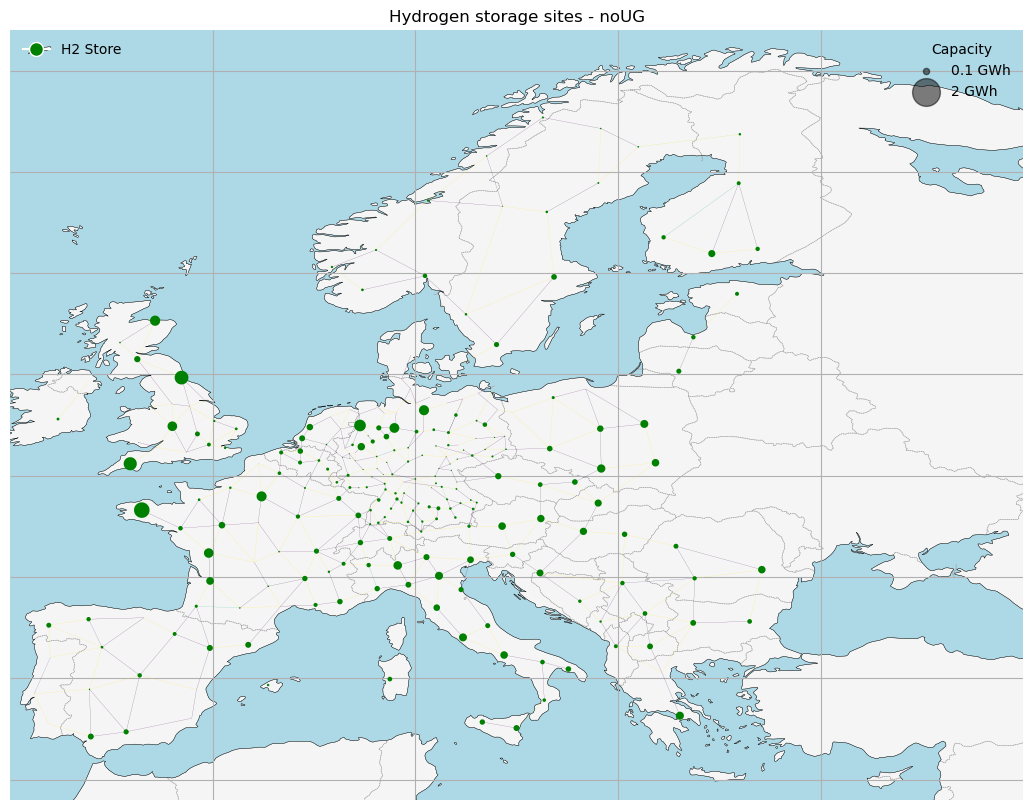

In [29]:
h2_store = n1.stores[n1.stores.carrier.isin(["H2 Store"])].assign(sto3=n1.stores_t.e.mean()).groupby(["bus", "carrier"]).sto3.sum().div(1e3) #GWh
#h2_store = h2_store.where(h2_store>0).fillna(0)

#h2_sites3 = n3.links[n3.links.carrier.isin(["H2 Electrolysis", "SMR CC", "SMR"])].assign(l3=n3.links_t.p1.mean().abs()).groupby(["bus1", "carrier"]).l3.sum()
h2_store.index = h2_store.index.set_levels(h2_store.index.levels[0].str.replace(' H2', ''), level=0)

EUROPE_BOUNDS = [-10, 40, 34, 72]
#carriers = ["H2 Electrolysis", "SMR CC", "SMR"]
carriers = ["H2 Store"]

colors = ["green"]

line_loading = n1.lines_t.p0.iloc[0] 
norm = plt.Normalize(vmin=0, vmax=100)

# Create a map with the PlateCarree projection centered on Europe

fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())


# Add features to the map
ax.add_feature(cfeature.LAND, linewidth=0.1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.1)
ax.add_feature(cfeature.BORDERS, linestyle=':', color="grey", linewidth=0.5)


n1.plot(ax=ax,margin=0.25,
    bus_sizes=h2_store/10,
    bus_colors={"H2 Store": "green"},
    line_colors=line_loading,
    line_norm=norm,
    line_cmap="viridis",
    line_widths=0.1,
    link_widths=0,
    projection=ccrs.PlateCarree(),
    color_geomap=True,
    )

# Create legend for the energy mix size
for size in [0.1, 2]:  
    ax.scatter([], [], c='k', alpha=0.5, s=size * 200,
               label=str(size) + ' GWh', 
               transform=ccrs.PlateCarree())
carrier_legend = [Line2D([0], [0], marker='o', color='w', label=carrier,
                         markerfacecolor=color, markersize=10) for carrier, color in zip(carriers, colors)]
legend1 = ax.legend(handles=carrier_legend, loc='upper left', scatterpoints=1, frameon=False)
ax.add_artist(legend1)


ax.legend(loc='upper right', scatterpoints=1, frameon=False, title='Capacity')

#ax.coastlines()
#ax.add_feature(cartopy.feature.BORDERS, color="grey", linewidth=0.5)
#plt.legend()
# Add gridlines
ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False)

# Set extent for Europe
ax.set_extent(EUROPE_BOUNDS, crs=ccrs.PlateCarree())

plt.title('Hydrogen storage sites - noUG')

plt.show()

In [31]:
h2_store.sort_values(ascending=False).head(10)

bus     carrier 
FR1 3   H2 Store    1.469773
GB0 8   H2 Store    1.149106
GB0 11  H2 Store    1.049131
DE1 29  H2 Store    0.829001
GB0 13  H2 Store    0.629659
DE1 57  H2 Store    0.613987
FR1 9   H2 Store    0.613803
DE1 54  H2 Store    0.583853
GB0 7   H2 Store    0.565298
FR1 23  H2 Store    0.555328
Name: sto3, dtype: float64

/Users/e7_qpham/miniconda3/envs/pypsa-eur/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/e7_qpham/miniconda3/envs/pypsa-eur/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


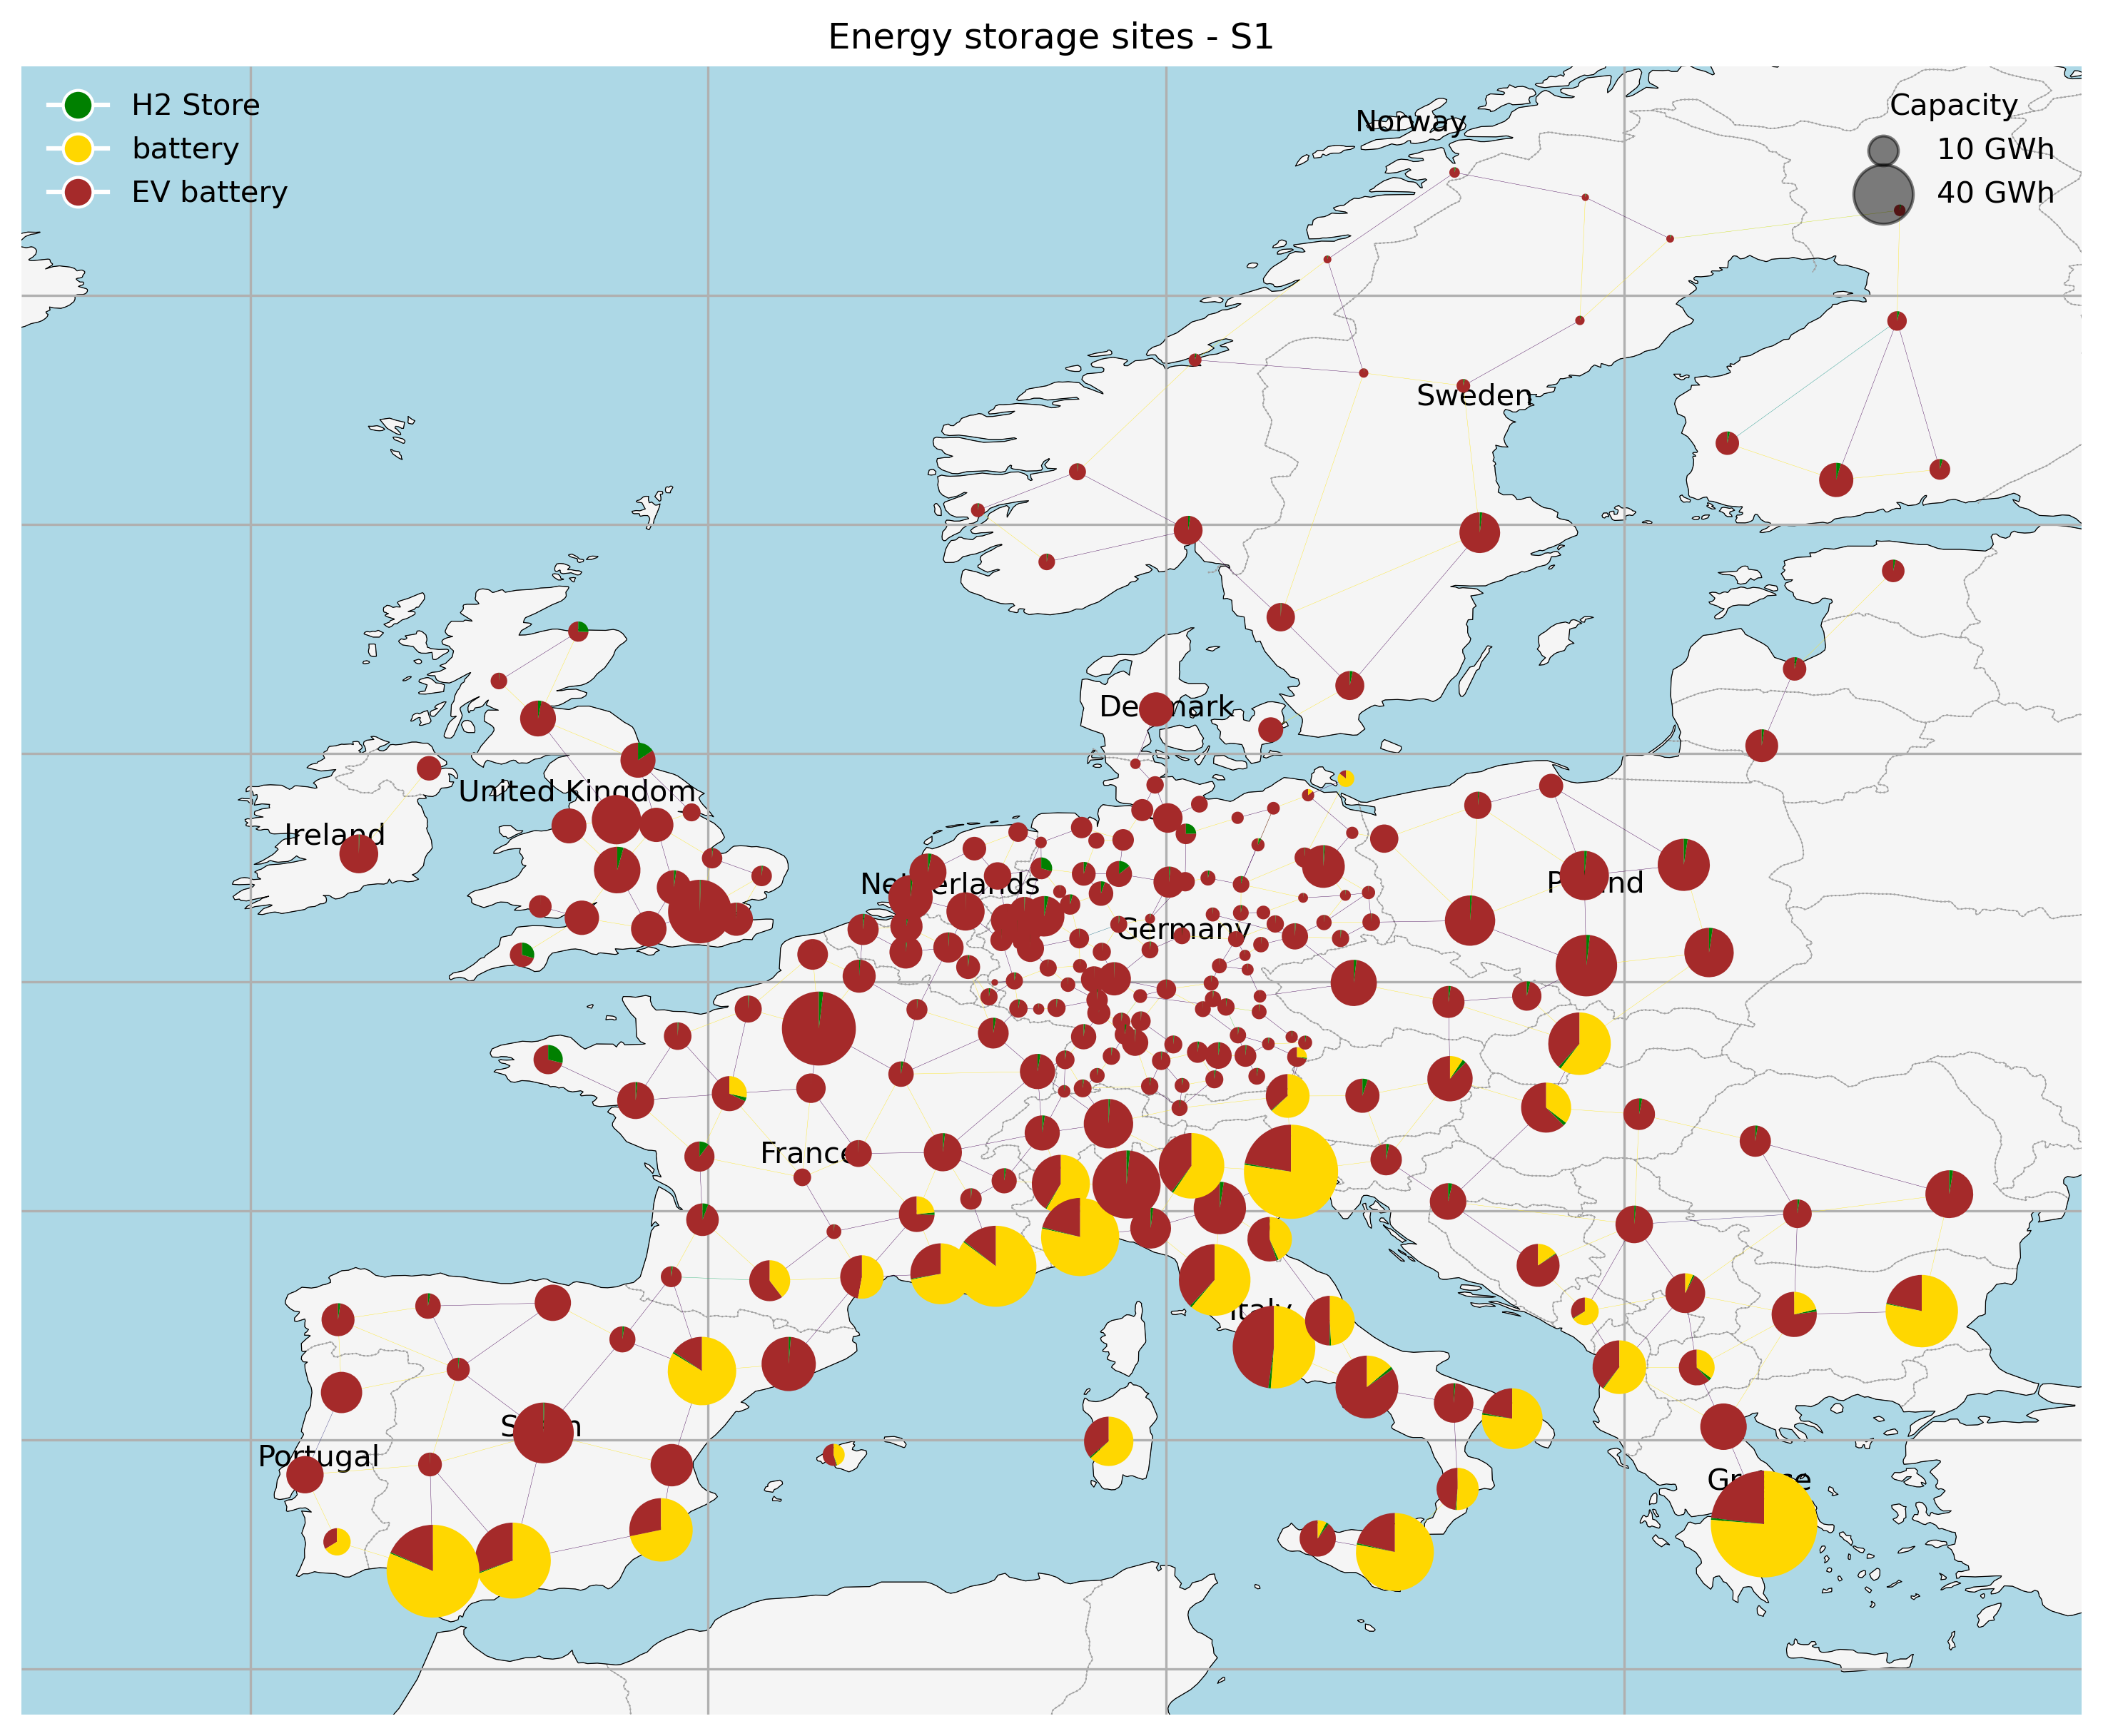

In [25]:
store = n1.stores[n1.stores.carrier.isin(["H2 Store", "battery", "battery storage"])].assign(sto3=n1.stores_t.e.mean()).groupby(["bus", "carrier"]).sto3.sum().div(1e3) #GWh
store = store.reset_index()

# Perform the regular expression extraction on the 'bus' column
store ['bus'] = store['bus'].str.extract(r'(\w+\s+\d+)', expand=False)

# Set the modified 'bus' column back as part of the multi-index
store = store.set_index(['bus', 'carrier'], drop=True)

series = store["sto3"]
series.index = series.index.set_levels(series.index.levels[1].str.replace('battery storage', 'EV battery'), level='carrier')



EUROPE_BOUNDS = [-15, 30, 34, 70]
#carriers = ["H2 Electrolysis", "SMR CC", "SMR"]
carriers = ["H2 Store", "battery", "EV battery"]

colors = ["green", "gold", "brown"]

line_loading = n1.lines_t.p0.iloc[0] 
norm = plt.Normalize(vmin=0, vmax=100)

# Create a map with the PlateCarree projection centered on Europe

fig = plt.figure(figsize=(15, 10),dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree())


# Add features to the map
ax.add_feature(cfeature.LAND, linewidth=0.1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.1)
ax.add_feature(cfeature.BORDERS, linestyle=':', color="grey", linewidth=0.5)

# Additional code to add country names
# This requires the natural_earth package which contains shapefiles with country names and borders
# Assuming the shapefile is at the 50m resolution which is commonly used for maps at this scale
countries = shapereader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shapereader.Reader(countries)

# List of countries for which you want to display the full name
full_name_countries = ['Germany', 'Sweden', 'Denmark', 'Spain', 'France', 'Netherlands',
                       'Portugal', 'United Kingdom', 'Ireland', 'Italy', 'Greece', 'Poland', 'Norway']

# Define a function to check if a point is within the Europe bounds
def is_in_europe(x, y):
    lon_min, lon_max, lat_min, lat_max = EUROPE_BOUNDS
    return lon_min <= x <= lon_max and lat_min <= y <= lat_max

# Correct coordinates for France's label
france_label_coords = (2.2137, 46.2276)  

# Adding country names to the plot, but only for the specified European countries
for country in reader.records():
    geometry = country.geometry
    name_long = country.attributes['NAME_LONG']
    # Manually set France's label coordinates
    if name_long == 'France':
        x, y = france_label_coords
    else:
        x, y = geometry.centroid.x, geometry.centroid.y
    # Check if the country is in the list of specific countries
    if name_long in full_name_countries:
        ax.text(x, y, name_long, ha='center', va='center', fontsize=10, transform=ccrs.PlateCarree())


n1.plot(ax=ax,margin=0.25,
    bus_sizes=series/50,
    bus_colors={"H2 Store": "green", "battery":"gold", "EV battery": "brown"},
    line_colors=line_loading,
    line_norm=norm,
    line_cmap="viridis",
    line_widths=0.1,
    link_widths=0,
    projection=ccrs.PlateCarree(),
    color_geomap=True,
    )

# Create legend for the energy mix size
for size in [10, 40]:  
    ax.scatter([], [], c='k', alpha=0.5, s=size * 10,
               label=str(size) + ' GWh', 
               transform=ccrs.PlateCarree())
carrier_legend = [Line2D([0], [0], marker='o', color='w', label=carrier,
                         markerfacecolor=color, markersize=10) for carrier, color in zip(carriers, colors)]
legend1 = ax.legend(handles=carrier_legend, loc='upper left', scatterpoints=1, frameon=False)
ax.add_artist(legend1)


ax.legend(loc='upper right', scatterpoints=1, frameon=False, title='Capacity')

#ax.coastlines()
#ax.add_feature(cartopy.feature.BORDERS, color="grey", linewidth=0.5)
#plt.legend()
# Add gridlines
ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False)

# Set extent for Europe
ax.set_extent(EUROPE_BOUNDS, crs=ccrs.PlateCarree())

plt.title('Energy storage sites - S1')

plt.show()


In [24]:
store.sort_values(by="sto3",ascending=False).head(20)

sto3
bus    carrier                   
GR1 0  battery          51.705676
ES1 7  battery          41.703420
IT1 9  battery          40.880319
FR1 16 battery          33.356333
FR1 9  battery storage  31.997805
IT1 4  battery          28.598739
IT1 3  battery          28.268903
IT1 6  battery storage  27.212972
BG1 1  battery          24.404683
GB0 5  battery storage  23.998155
ES1 4  battery          23.819186
ES1 11 battery          23.370005
PL1 0  battery storage  22.132542
ES1 2  battery storage  21.903456
IT1 14 battery          20.875353
IT1 7  battery storage  19.912327
IT1 14 battery storage  19.471623
IT1 8  battery          18.715445
ES1 3  battery storage  17.329730
ES1 12 battery          17.201815

/Users/e7_qpham/miniconda3/envs/pypsa-eur/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


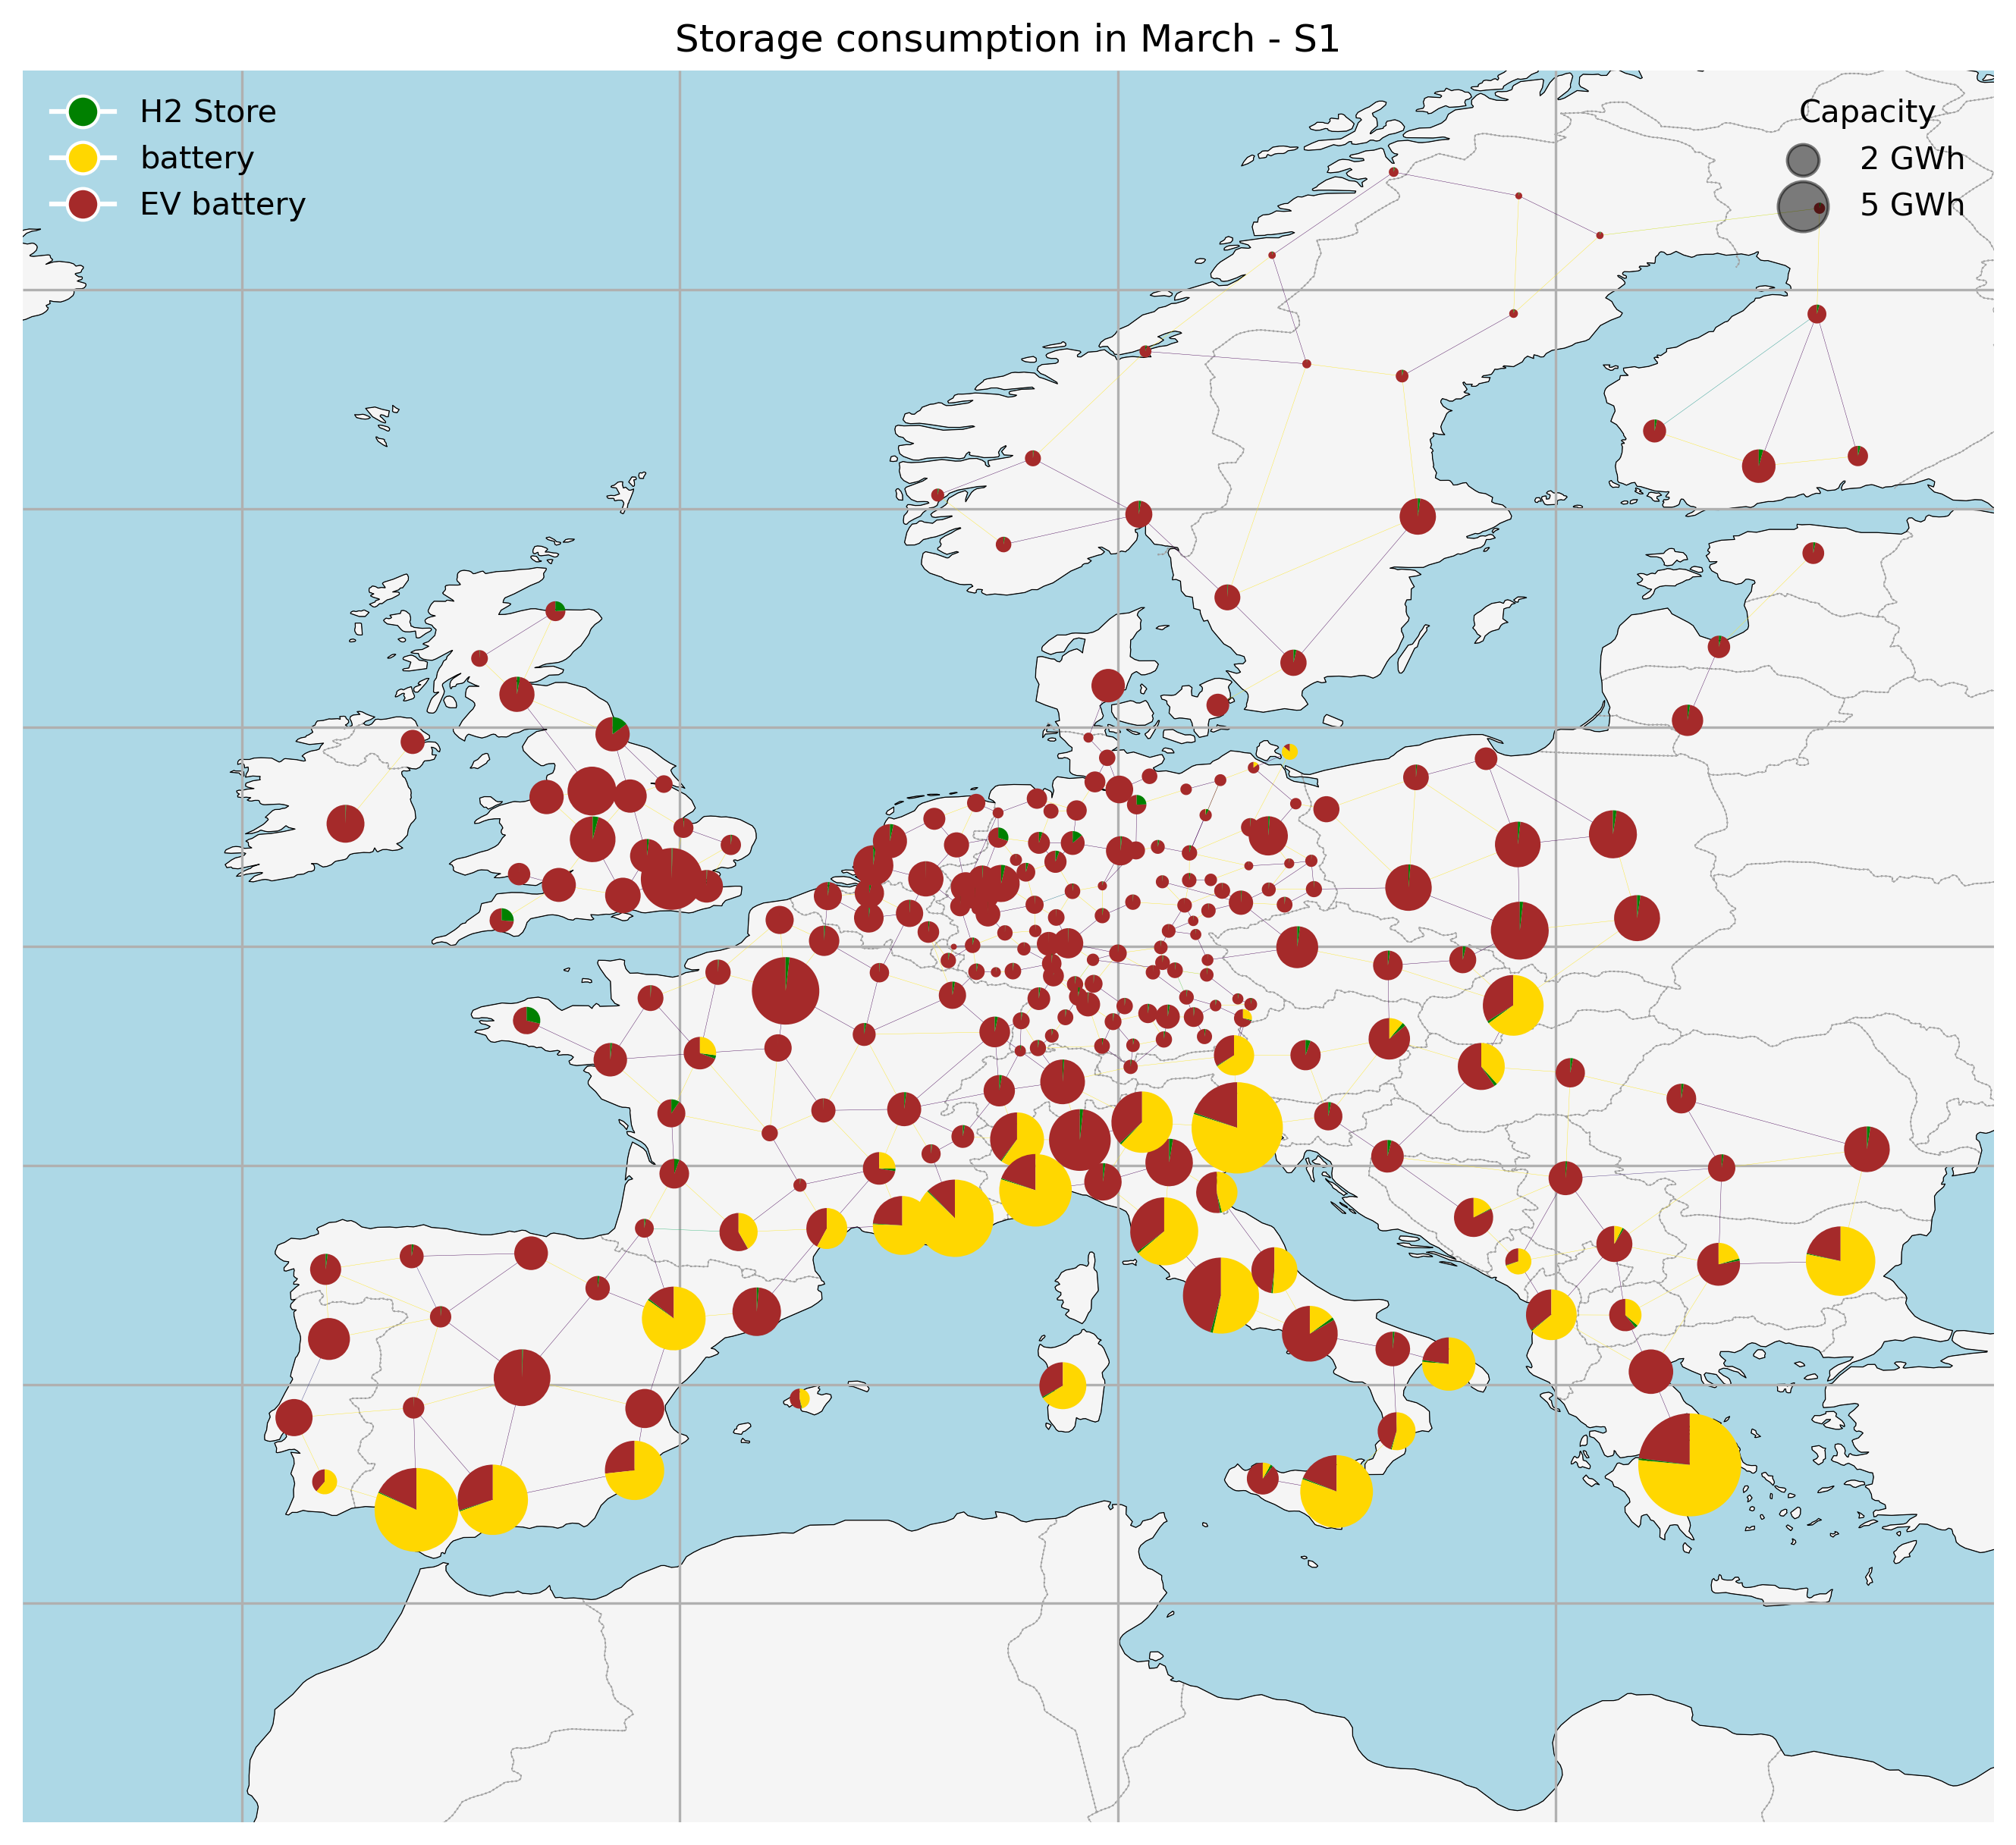

In [22]:
store = n1.stores[n1.stores.carrier.isin(["H2 Store", "battery", "battery storage"])].assign(sto3=n1.stores_t.e.loc["2013-03"].mean()).groupby(["bus", "carrier"]).sto3.sum().div(1e3) #GWh
store = store.reset_index()

# Perform the regular expression extraction on the 'bus' column
store ['bus'] = store['bus'].str.extract(r'(\w+\s+\d+)', expand=False)

# Set the modified 'bus' column back as part of the multi-index
store = store.set_index(['bus', 'carrier'], drop=True)

series = store["sto3"]
series.index = series.index.set_levels(series.index.levels[1].str.replace('battery storage', 'EV battery'), level='carrier')



EUROPE_BOUNDS = [-15, 30, 30, 70]
#carriers = ["H2 Electrolysis", "SMR CC", "SMR"]
carriers = ["H2 Store", "battery", "EV battery"]

colors = ["green", "gold", "brown"]

line_loading = n1.lines_t.p0.iloc[0] 
norm = plt.Normalize(vmin=0, vmax=100)

# Create a map with the PlateCarree projection centered on Europe

fig = plt.figure(figsize=(15, 10),dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree())


# Add features to the map
ax.add_feature(cfeature.LAND, linewidth=0.1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.1)
ax.add_feature(cfeature.BORDERS, linestyle=':', color="grey", linewidth=0.5)


n1.plot(ax=ax,margin=0.25,
    bus_sizes=series/50,
    bus_colors={"H2 Store": "green", "battery":"gold", "EV battery": "brown"},
    line_colors=line_loading,
    line_norm=norm,
    line_cmap="viridis",
    line_widths=0.1,
    link_widths=0,
    projection=ccrs.PlateCarree(),
    color_geomap=True,
    )

# Create legend for the energy mix size
for size in [2, 5]:  # Example sizes, you should set the actual sizes you want to display
    ax.scatter([], [], c='k', alpha=0.5, s=size * 50,
               label=str(size) + ' GWh',  # Adjust label to match your data units
               transform=ccrs.PlateCarree())
carrier_legend = [Line2D([0], [0], marker='o', color='w', label=carrier,
                         markerfacecolor=color, markersize=10) for carrier, color in zip(carriers, colors)]
legend1 = ax.legend(handles=carrier_legend, loc='upper left', scatterpoints=1, frameon=False)
ax.add_artist(legend1)


ax.legend(loc='upper right', scatterpoints=1, frameon=False, title='Capacity')

#ax.coastlines()
#ax.add_feature(cartopy.feature.BORDERS, color="grey", linewidth=0.5)
#plt.legend()
# Add gridlines
ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False)

# Set extent for Europe
ax.set_extent(EUROPE_BOUNDS, crs=ccrs.PlateCarree())

plt.title('Storage consumption in March - S1')

plt.show()


In [18]:
store.sort_values(by="sto3",ascending=False).head(20)

sto3
bus    carrier                  
DE1 4  battery storage  9.896383
DE1 49 battery storage  8.652088
DE1 45 battery storage  5.907717
DE1 44 battery storage  5.852603
DE1 53 battery storage  5.469653
DE1 24 battery storage  5.018020
DE1 33 battery storage  4.995817
DE1 80 battery storage  3.980219
DE1 40 battery storage  3.809945
DE1 22 battery storage  3.787453
DE1 37 battery storage  3.703965
DE1 13 battery storage  3.695501
DE1 3  battery storage  3.285331
DE1 54 battery storage  3.197818
DE1 1  battery storage  3.123298
DE1 10 battery storage  3.022513
DE1 84 battery storage  3.001676
DE1 59 battery storage  2.979789
DE1 28 battery storage  2.849408
DE1 39 battery storage  2.813852

In [27]:
DE_regions = gpd.read_file(r"./gadm_410-levels-ADM_1-DEU.gpkg")
DE_regions = DE_regions.drop(["GID_0", "GID_1", "COUNTRY"],axis=1)
DE_regions["centroid"] = DE_regions["geometry"].centroid

DE_regions

/var/folders/2b/17ddx8s13fb7jb4wkn0p31b80000gn/T/ipykernel_46462/3774344237.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  DE_regions["centroid"] = DE_regions["geometry"].centroid


NAME_1                                           geometry  \
0        Baden-Württemberg  MULTIPOLYGON (((8.35002 47.57062, 8.34778 47.5...   
1                   Bayern  MULTIPOLYGON (((11.41009 47.49540, 11.41005 47...   
2                   Berlin  MULTIPOLYGON (((13.50022 52.61379, 13.49855 52...   
3              Brandenburg  MULTIPOLYGON (((13.32220 51.43674, 13.32402 51...   
4                   Bremen  MULTIPOLYGON (((8.67501 53.17805, 8.67532 53.1...   
5                  Hamburg  MULTIPOLYGON (((10.17575 53.71111, 10.17562 53...   
6                   Hessen  MULTIPOLYGON (((8.88614 49.41698, 8.88546 49.4...   
7   Mecklenburg-Vorpommern  MULTIPOLYGON (((11.56936 53.16780, 11.56944 53...   
8            Niedersachsen  MULTIPOLYGON (((10.36772 51.55516, 10.36846 51...   
9      Nordrhein-Westfalen  MULTIPOLYGON (((6.57956 50.37709, 6.57518 50.3...   
10         Rheinland-Pfalz  MULTIPOLYGON (((7.64112 49.05281, 7.63539 49.0...   
11                Saarland  MULTIPOLYGON (((7.19729 49.11891, 7.19703 49.1...   
12                 Sachsen  MULTIPOLYGON (((12.35469 50.24796, 12.35507 50...   
13          Sachsen-Anhalt  MULTIPOLYGON (((12.24043 50.96210, 12.24105 50...   
14      Schleswig-Holstein  MULTIPOLYGON (((10.51093 53.37207, 10.50681 53...   
15               Thüringen  MULTIPOLYGON (((11.25325 50.27047, 11.25328 50...   

                     centroid  
0    POINT (9.04909 48.53753)  
1   POINT (11.42000 48.94784)  
2   POINT (13.40185 52.50153)  
3   POINT (13.39777 52.47288)  
4    POINT (8.74464 53.19772)  
5   POINT (10.02079 53.54638)  
6    POINT (9.03105 50.60322)  
7   POINT (12.55396 53.75402)  
8    POINT (9.15923 52.76588)  
9    POINT (7.56208 51.47971)  
10   POINT (7.44911 49.91369)  
11   POINT (6.95314 49.38437)  
12  POINT (13.34857 51.05233)  
13  POINT (11.70068 52.01318)  
14   POINT (9.81008 54.18288)  
15  POINT (11.02488 50.90387)

/Users/e7_qpham/miniconda3/envs/pypsa-eur/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/e7_qpham/miniconda3/envs/pypsa-eur/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/e7_qpham/miniconda3/envs/pypsa-eur/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


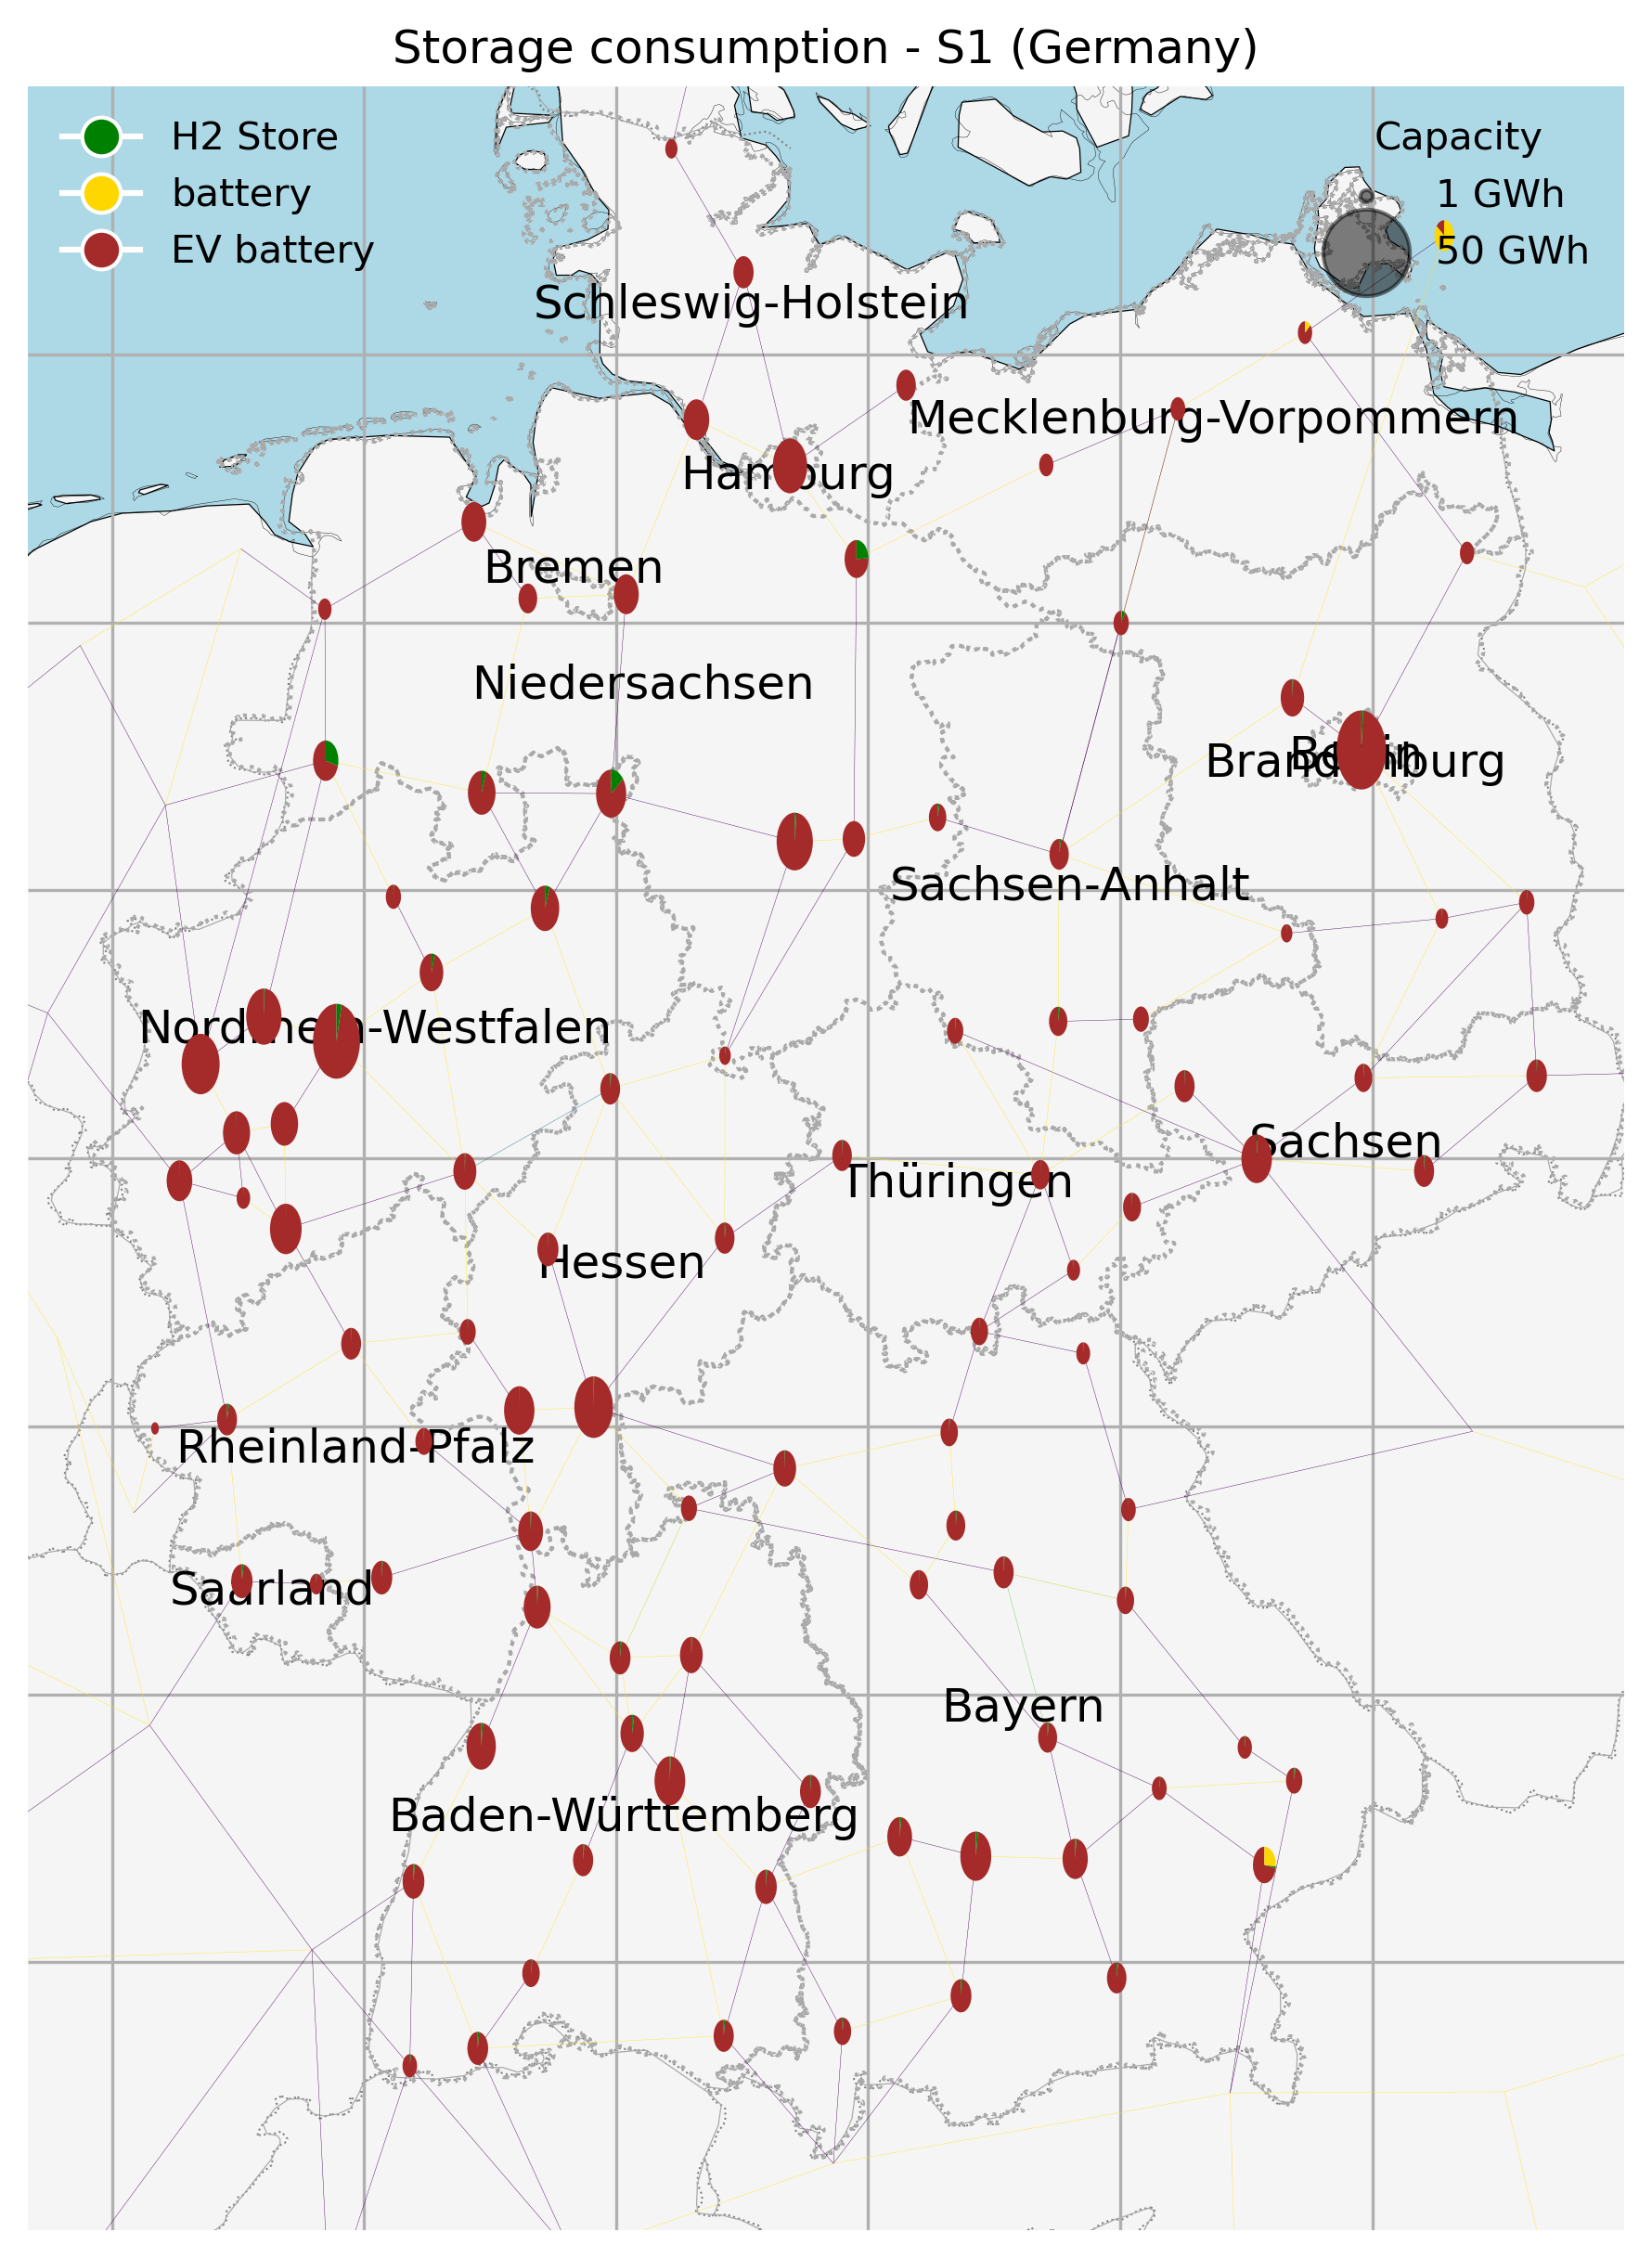

In [32]:
store = n1.stores[n1.stores.carrier.isin(["H2 Store", "battery", "battery storage"])].assign(sto3=n1.stores_t.e.mean()).groupby(["bus", "carrier"]).sto3.sum().div(1e3).filter(like="DE") #GWh
store = store.reset_index()

# Perform the regular expression extraction on the 'bus' column
store ['bus'] = store['bus'].str.extract(r'(\w+\s+\d+)', expand=False)

# Set the modified 'bus' column back as part of the multi-index
store = store.set_index(['bus', 'carrier'], drop=True)

series = store["sto3"]
series.index = series.index.set_levels(series.index.levels[1].str.replace('battery storage', 'EV battery'), level='carrier')



EUROPE_BOUNDS = [5.5, 15, 47, 55]
#carriers = ["H2 Electrolysis", "SMR CC", "SMR"]
carriers = ["H2 Store", "battery", "EV battery"]

colors = ["green", "gold", "brown"]

line_loading = n1.lines_t.p0.iloc[0] 
norm = plt.Normalize(vmin=0, vmax=100)

# Create a map with the PlateCarree projection centered on Europe

fig = plt.figure(figsize=(15, 10),dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree())


# Add features to the map
ax.add_feature(cfeature.LAND, linewidth=0.1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.1)
ax.add_feature(cfeature.BORDERS, linestyle=':', color="grey", linewidth=0.5)


n1.plot(ax=ax,margin=0.25,
    bus_sizes=series/500,
    bus_colors={"H2 Store": "green", "battery":"gold", "EV battery": "brown"},
    line_colors=line_loading,
    line_norm=norm,
    line_cmap="viridis",
    line_widths=0.1,
    link_widths=0,
    projection=ccrs.PlateCarree(),
    color_geomap=True,
    )

boundary_style = {'edgecolor': 'darkgray', 'linestyle': ':', 'linewidth': 1}
# Plot the German states boundaries
DE_regions.boundary.plot(ax=ax, **boundary_style)  

# Add state names to the plot
for idx, row in DE_regions.iterrows():  # Uncomment when DE_regions is defined
    name = row['NAME_1']
    centroid = row['centroid']
    ax.text(centroid.x, centroid.y, name, ha='center', va='center', fontsize=12, transform=ccrs.PlateCarree())

# Create legend for the energy mix size
for size in [1, 50]:  # Example sizes, you should set the actual sizes you want to display
    ax.scatter([], [], c='k', alpha=0.5, s=size * 10,
               label=str(size) + ' GWh',  # Adjust label to match your data units
               transform=ccrs.PlateCarree())
carrier_legend = [Line2D([0], [0], marker='o', color='w', label=carrier,
                         markerfacecolor=color, markersize=10) for carrier, color in zip(carriers, colors)]
legend1 = ax.legend(handles=carrier_legend, loc='upper left', scatterpoints=1, frameon=False)
ax.add_artist(legend1)


ax.legend(loc='upper right', scatterpoints=1, frameon=False, title='Capacity')

#ax.coastlines()
#ax.add_feature(cartopy.feature.BORDERS, color="grey", linewidth=0.5)
#plt.legend()
# Add gridlines
ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False)

# Set extent for Europe
#ax.set_extent(EUROPE_BOUNDS, crs=ccrs.PlateCarree())
# Set the extent of the map to Germany
ax.set_extent([5.5, 15, 47, 55], crs=ccrs.PlateCarree())

plt.title('Storage consumption - S1 (Germany)')

plt.show()


/Users/e7_qpham/miniconda3/envs/pypsa-eur/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/e7_qpham/miniconda3/envs/pypsa-eur/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Users/e7_qpham/miniconda3/envs/pypsa-eur/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


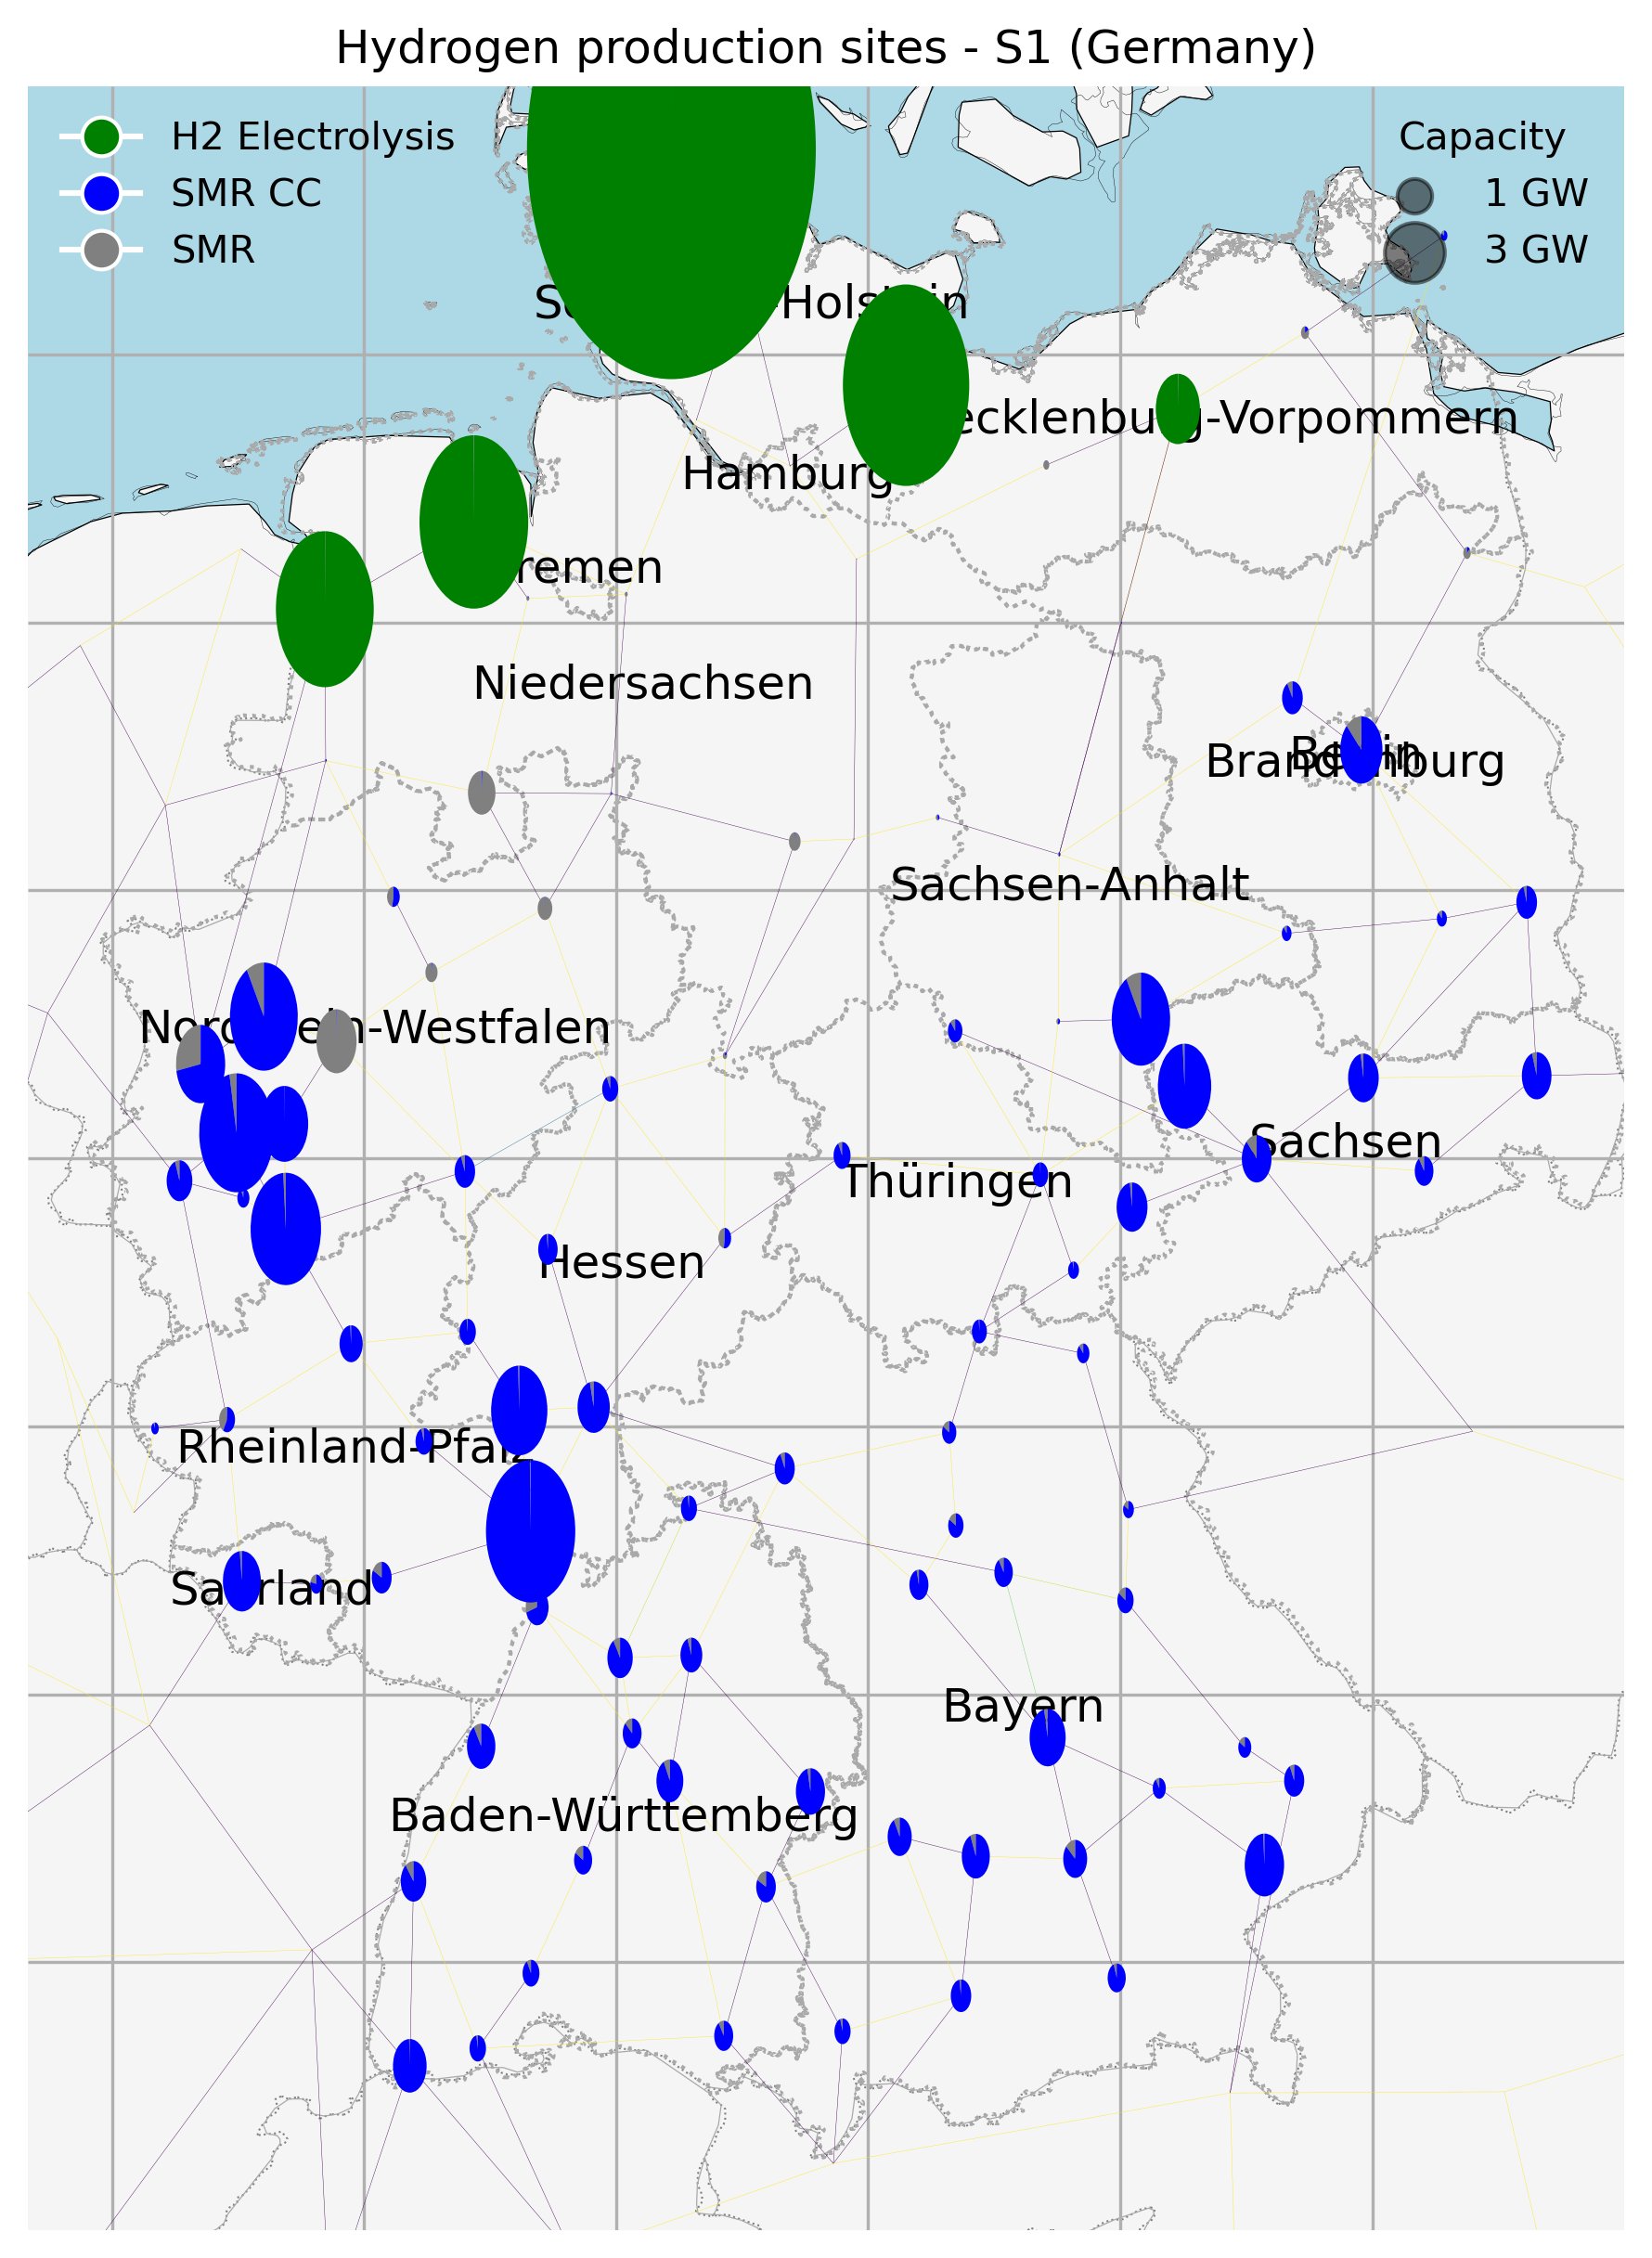

In [41]:
h2_sites1 = n1.links[n1.links.carrier.isin(["H2 Electrolysis", "SMR CC", "SMR"])].assign(l1=n1.links_t.p1.mean().abs()).groupby(["bus1", "carrier"]).l1.sum().filter(like="DE")
h2_sites1.index = h2_sites1.index.set_levels(h2_sites1.index.levels[0].str.replace(' H2', ''), level=0)

EUROPE_BOUNDS = [-15, 30, 30, 70]
carriers = ["H2 Electrolysis", "SMR CC", "SMR"]
colors = ["green", "blue", "gray"]

line_loading = n1.lines_t.p0.iloc[0] 
norm = plt.Normalize(vmin=0, vmax=100)

# Create a map with the PlateCarree projection centered on Europe

fig = plt.figure(figsize=(15, 10),dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree())


# Add features to the map
ax.add_feature(cfeature.LAND, linewidth=0.1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.1)
ax.add_feature(cfeature.BORDERS, linestyle=':', color="grey", linewidth=0.5)


n1.plot(ax=ax,margin=0.25,
    bus_sizes=h2_sites1/4000,
    bus_colors={"H2 Electrolysis": "green", "SMR CC": "blue", "SMR": "gray"},
    line_colors=line_loading,
    line_norm=norm,
    line_cmap="viridis",
    line_widths=0.1,
    link_widths=0,
    projection=ccrs.PlateCarree(),
    color_geomap=True,
    )
boundary_style = {'edgecolor': 'darkgray', 'linestyle': ':', 'linewidth': 1}
# Plot the German states boundaries
DE_regions.boundary.plot(ax=ax, **boundary_style)  

# Add state names to the plot
for idx, row in DE_regions.iterrows():  # Uncomment when DE_regions is defined
    name = row['NAME_1']
    centroid = row['centroid']
    ax.text(centroid.x, centroid.y, name, ha='center', va='center', fontsize=12, transform=ccrs.PlateCarree())

# Create legend for the energy mix size
for size in [1, 3]:  # Example sizes, you should set the actual sizes you want to display
    ax.scatter([], [], c='k', alpha=0.5, s=size * 80,
               label=str(size) + ' GW',  # Adjust label to match your data units
               transform=ccrs.PlateCarree())
carrier_legend = [Line2D([0], [0], marker='o', color='w', label=carrier,
                         markerfacecolor=color, markersize=10) for carrier, color in zip(carriers, colors)]
legend1 = ax.legend(handles=carrier_legend, loc='upper left', scatterpoints=1, frameon=False)
ax.add_artist(legend1)


ax.legend(loc='upper right', scatterpoints=1, frameon=False, title='Capacity')

#ax.coastlines()
#ax.add_feature(cartopy.feature.BORDERS, color="grey", linewidth=0.5)
#plt.legend()
# Add gridlines
ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False)

# Set extent for Europe
#ax.set_extent(EUROPE_BOUNDS, crs=ccrs.PlateCarree())
ax.set_extent([5.5, 15, 47, 55], crs=ccrs.PlateCarree())

plt.title('Hydrogen production sites - S1 (Germany)')

plt.show()

In [42]:
h2_sites1.sort_values(ascending=False)

bus1    carrier        
DE1 72  H2 Electrolysis    2953.612355
DE1 67  H2 Electrolysis     565.175045
DE1 56  H2 Electrolysis     417.999667
DE1 5   H2 Electrolysis     338.692370
DE1 70  SMR CC              281.531565
                              ...     
DE1 65  H2 Electrolysis       0.000125
DE1 0   H2 Electrolysis       0.000123
DE1 8   H2 Electrolysis       0.000121
DE1 96  H2 Electrolysis       0.000119
DE1 41  H2 Electrolysis       0.000119
Name: l1, Length: 306, dtype: float64

In [48]:
h2_sites1.filter(like="SMR CC").sum()

2279.4171806483387